In [103]:
#The HR Analytics dateset from kaggle competitions 
#Import of  necessary libraries, Modules and classifiers
import numpy as np  #fundamental package for scientific computing with Python
import pandas as pd #package providing fast, flexible, and expressive data structures
import matplotlib.pyplot as plt #for plotting different kinds of diagrams
#commands in cells below the cell that outputs a plot will not affect the plot inline command 
#(commentation on the same line causes an error):
%matplotlib inline 
import seaborn as sns #visualization library based on matplotlib, for statistical data visualization


hr_data=pd.read_csv('.\HR_comma_sep.csv',header=0) #read the data from a csv-file; ensure that the  values 
#are separated by commas otherwise you need to specify the delimiter explicitly within the load-statement

hr_data_copy=hr_data.copy()  #create a deep copy of the data set for demonstrating how to handle missing values (mv)

hr_data.head() #show the first five entries; attribute in brackets will give the # of printed lines 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [104]:
hr_data.info() #attribut specifications

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [105]:
hr_data.describe()  # show some statistics about the attributes of the data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Skew is: -0.476360341284


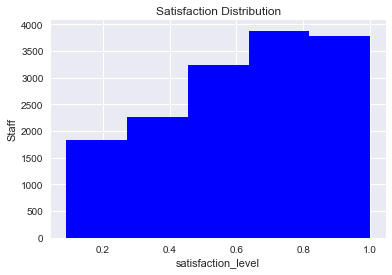

In [106]:
#To observe the distribution of satisfaction level among the employees we generate metrics 
#of skewness and plot the histogram of the satisfaction level.
print ("Skew is:", hr_data.satisfaction_level.skew()) #*.skew() shows tendency (0=no skewness, (-)=left skewed)

plt.hist(hr_data.satisfaction_level, color='blue',bins=5) #plot the histogram
#plt.hist needs argument "data" in form of a 1d numpy array
#we can adress columns as numpy arrays by just adding their name to the data frame (e.g. df.variable_name).
#we choose the parameter color to be blue --> blue histogram and bins=5 to fit the data to 5 pillars.

plt.xlabel('satisfaction_level') #naming the x-axis
plt.ylabel('Staff') #labeling the y-axis
plt.title('Satisfaction Distribution') 
 
plt.show() #display the plot

In [107]:
if(not hr_data.isnull().values.any()):  #Checking for NaN-values; any() returns True if any element of the iterable is true. 
    #If the iterable is empty, it returns False.  
    print('QC (Y): Dataset does not contain missing values')
else:
    print('QC (N): Dataset contains missing values')

QC (Y): Dataset does not contain missing values


In [108]:
#for showing how to handle missing values(mv), we randomly create some NaN-values inside the dataset 
import random
ix = [(row, col) for row in range(hr_data_copy.shape[0]) for col in range(hr_data_copy.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):   #for a 10% random sample in the sequenz ix-array 
       hr_data_copy.iloc[row, col] = np.nan                  #entries replaced by NaN-values

In [109]:
hr_data_copy.head() #show the first five entries again with NaN-entries 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,1.0,0.0,sales,low
1,0.80,0.86,5.0,262.0,6.0,0.0,1.0,0.0,sales,medium
2,0.11,NaN,7.0,272.0,4.0,0.0,1.0,NaN,NaN,medium
3,0.72,0.87,5.0,223.0,5.0,NaN,1.0,NaN,sales,low
4,0.37,0.52,NaN,159.0,3.0,0.0,NaN,0.0,NaN,low


In [110]:
hr_data_copy.describe() #just to show the mv-effect, now less entries, because of mv

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,13516.000000,13487.000000,13467.000000,13541.000000,13481.000000,13490.000000,13473.000000,13534.000000
mean,0.612581,0.715373,3.800847,200.943948,3.491061,0.143884,0.238477,0.021723
std,0.248096,0.171223,1.232387,50.045265,1.453002,0.350985,0.426168,0.145783
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [111]:
##there are 3 possibilities for handling missing values(mv): 
#1.to ignore  #2.to impute(fill)  3.to drop the datapoint with mv

In [112]:
##2.way - impute
#imputation strategies:
#  “mean” to replace missing values using the mean along the axis.
#  “median” to replace missing values using the median along the axis.
#  “most_frequent” to replace missing using the most frequent value along the axis.
hr_no_missing_f=hr_data_copy.fillna(hr_data_copy.iloc[:10].median()) 
hr_no_missing_f.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.593046,0.724912,3.923328,203.136542,3.542570,0.129409,0.315954,0.019601
std,0.242784,0.164844,1.222915,48.017785,1.386035,0.335663,0.464910,0.138630
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.415000,0.570000,3.000000,159.000000,3.000000,0.000000,0.000000,0.000000
50%,0.600000,0.750000,4.000000,211.000000,3.000000,0.000000,0.000000,0.000000
75%,0.800000,0.850000,5.000000,241.000000,4.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [113]:
#3.way - drop mv's
hr_no_missing_d = hr_data_copy.dropna()
hr_no_missing_d.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,1.0,0.0,sales,low
1,0.80,0.86,5.0,262.0,6.0,0.0,1.0,0.0,sales,medium
8,0.89,1.00,5.0,224.0,5.0,0.0,1.0,0.0,sales,low
13,0.41,0.55,2.0,148.0,3.0,0.0,1.0,0.0,sales,low
14,0.36,0.56,2.0,137.0,3.0,0.0,1.0,0.0,sales,low


In [114]:
hr_no_missing_d.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000
mean,0.612850,0.716649,3.776525,201.096922,3.488052,0.140700,0.250430,0.024661
std,0.249519,0.172913,1.237230,49.930556,1.418601,0.347745,0.433302,0.155104
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.430000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,199.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,246.000000,4.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [115]:
hr_data.info() #attribut specifications, shows the datatype-information about the attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [116]:
print('Departments: ', ', '.join(hr_data['sales'].unique())) #show and join the unique entries in sales
#with the more precise description "departments"
print('Salary levels: ', ', '.join(hr_data['salary'].unique())) #show and join the unique entries in salery 
#with a descriptive level 

Departments:  sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RandD
Salary levels:  low, medium, high


In [117]:
hr_data.rename(columns={'sales':'department'}, inplace=True) #rename Column, note: you do need to specify the
#existing label first followed by the new label to rename it to afterward 
hr_data_new = pd.get_dummies(hr_data, ['department', 'salary'] ,drop_first = True) #Whether to get k-1 dummies out 
#of k categorical levels by removing the first level. New in Pandas version 0.18.0.
hr_data_new.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [118]:
'''Observe that "IT" and "high" are the baseline levels for the assigned department and salary level, respectively. 
Also note that we saved the data with dummy variables as another dataframe in case we need to access the string values, 
such as for a cross-tabulation table.'''

hr_data_new.describe() #Generates descriptive statistics that summarize the central tendency, 
#dispersion and shape of a dataset’s distribution. 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.487766,0.429762
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.499867,0.495059
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


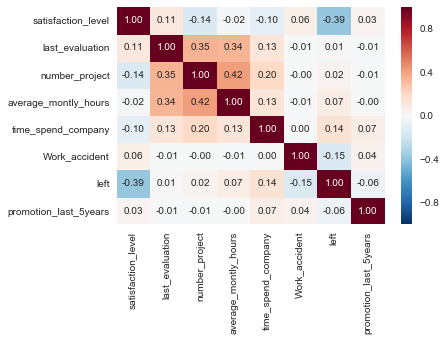

In [119]:
# Correlation matrix is used to do some basic visualizations and show any relationships in the data.
sns.heatmap(hr_data.corr(), annot=True,fmt='.2f');  #compute pairwise correlation of columns, 
#excluding NA/null values; annot=True presents heatmap with values, the format-configuration 
#makes it better to read (2 decimal places), <;> is hiding the processing steps

In [120]:
hr_data_new.columns #show the column names of new table 

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department_RandD', 'department_accounting',
       'department_hr', 'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_low', 'salary_medium'],
      dtype='object')

In [121]:
#proportion of leaving and staying in the different departments: 
dept_table = pd.crosstab(hr_data['department'], hr_data['left'],normalize='index')
#We created a cross tabulation of columns left and department, the normalize parameter is
#dividing all values by the sum of values.
#parameter list for pandas.crosstab can be found in pandas documentation:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
dept_table.index.names = ['Department'] #naming of the index column
dept_table #print the cross tab

left,0,1
Department,,
IT,0.777506,0.222494
RandD,0.846252,0.153748
accounting,0.734029,0.265971
hr,0.709066,0.290934
management,0.855556,0.144444
marketing,0.763403,0.236597
product_mng,0.780488,0.219512
sales,0.755072,0.244928
support,0.751009,0.248991


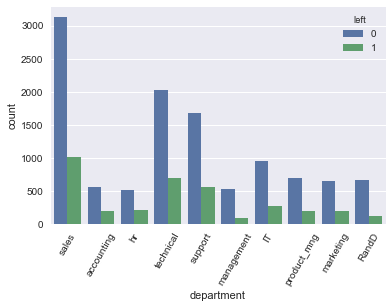

In [122]:
g=sns.countplot(x='department', hue='left', data=hr_data) #Show the number of observations 
#in each categorical bin of 'department' using bars.
for item in g.get_xticklabels():  #for every entry in x rotate the x-axis for better reading 
    item.set_rotation(60)         # No'in brackets = degrees in positive direction

In [123]:
#We define a function describe the bars with its total and relative # 
def annotate_bars(bar_plt, bar_plt_var, by=None, x_offset=0, y_offset=0, txt_color="white", fnt_size=12, fnt_weight='bold'):
    if by is None:
        for p in bar_plt.patches:
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /bar_plt_var.count(), 1) )+ "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)
    else:
        grouped = bar_plt_var.groupby(by)
        for p in bar_plt.patches:            
            #This part is tricky. The problem is that not each x-tick gets drawn in order, i.e. yes/no of the first group 
            #then yes/no of the second group located on the next tick, but rather all the yes on all the x-ticks get drawn first
            # then all the nos next. So we need to know we are using a patch that belongs to which tick (the x-tick) ultimately
            #refers to one of the groups. So, we get the x absolute coordinate, round it to know this patch is closest to which 
            #tick (Assuming that it will always belong to its closest tick), then get the group count of that tick and use it as
            # a total to compute the percentage. (Code from E-M-A-D; https://www.kaggle.com/etakla)
            total = grouped.get_group(bar_plot.get_xticks()[int(round(p.get_x()))]).count()
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /total, 1) )+ "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)

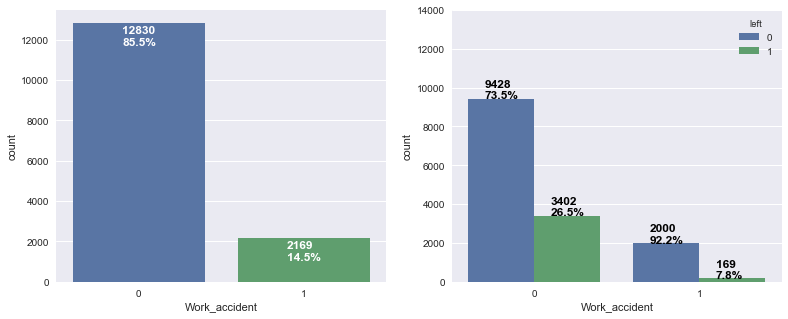

In [124]:
fig, axs = plt.subplots(ncols= 2, figsize=(13, 5))

work_accidents_plt = sns.countplot(hr_data.Work_accident, ax=axs[0]);
annotate_bars(bar_plt=work_accidents_plt, bar_plt_var=hr_data.Work_accident, x_offset=0.3, y_offset=1100)
    
bar_plot = sns.countplot(x=hr_data.Work_accident, hue=hr_data.left, ax=axs[1])
annotate_bars(bar_plt=bar_plot, by=hr_data.Work_accident, bar_plt_var=hr_data.Work_accident, x_offset=0.1, txt_color="black")
bar_plot.set(ylim=(0,14000));

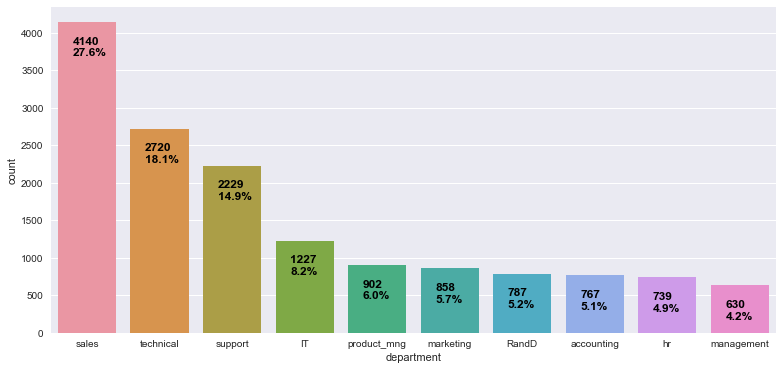

In [125]:
fig, axs = plt.subplots(figsize=(13, 6))

department_plt = sns.countplot(hr_data.department, order = hr_data.department.value_counts().index);

annotate_bars(bar_plt=department_plt, bar_plt_var=hr_data.department, x_offset=0.2, y_offset=450, txt_color="black")

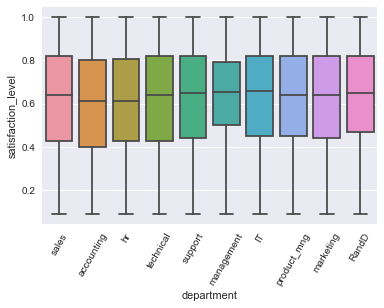

In [126]:
g=sns.boxplot(x='department', y='satisfaction_level', data=hr_data) #Draw a box plot to show 
#distributions (satisfaction level) with respect to categories (departments). A box plot (or
#box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates 
#comparisons between variables or across levels of a categorical variable. The box shows the 
#quartiles of the dataset while the whiskers extend to show the rest of the distribution, 
#except for points that are determined to be “outliers”. 
for item in g.get_xticklabels():  #rotate the x-axis for better reading 
    item.set_rotation(60) # No'in brackets = degrees in positive direction

In [127]:
def annotate_bars(bar_plt, bar_plt_var, by=None, x_offset=0, y_offset=0, txt_color="white", fnt_size=12, fnt_weight='bold'):
    if by is None:
        for p in bar_plt.patches:
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /bar_plt_var.count(), 1) )+ "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)
    else:
        grouped = bar_plt_var.groupby(by)
        for p in bar_plt.patches:            
            #This part is tricky. The problem is that not each x-tick gets drawn in order, i.e. yes/no of the first group 
            #then yes/no of the second group located on the next tick, but rather all the yes on all the x-ticks get drawn first
            # then all the nos next. So we need to know we are using a patch that belongs to which tick (the x-tick) ultimately
            #refers to one of the groups. So, we get the x absolute coordinate, round it to know this patch is closest to which 
            #tick (Assuming that it will always belong to its closest tick), then get the group count of that tick and use it as
            # a total to compute the percentage. (Code from E-M-A-D; https://www.kaggle.com/etakla)
            total = grouped.get_group(bar_plot.get_xticks()[int(round(p.get_x()))]).count()
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /total, 1) )+ "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)


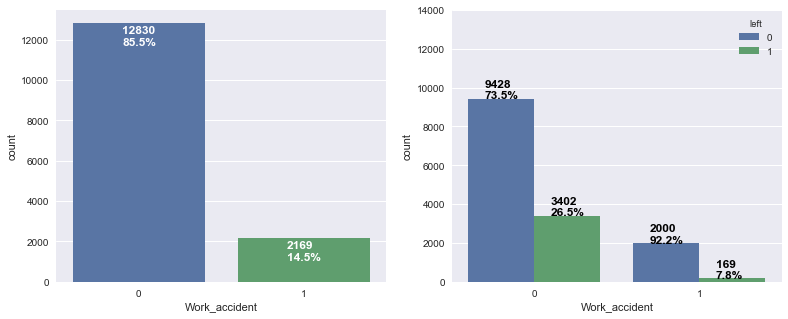

In [128]:
fig, axs = plt.subplots(ncols= 2, figsize=(13, 5))

work_accidents_plt = sns.countplot(hr_data.Work_accident, ax=axs[0]);
annotate_bars(bar_plt=work_accidents_plt, bar_plt_var=hr_data.Work_accident, x_offset=0.3, y_offset=1100)
    
bar_plot = sns.countplot(x=hr_data.Work_accident, hue=hr_data.left, ax=axs[1])
annotate_bars(bar_plt=bar_plot, by=hr_data.Work_accident, bar_plt_var=hr_data.Work_accident, x_offset=0.1, txt_color="black")
bar_plot.set(ylim=(0,14000));

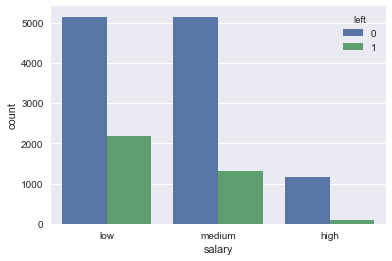

In [129]:
g=sns.countplot(x='salary', hue='left', data=hr_data) #shows the number of observations in 
#each categorical bin using bars; here: the dependecy of staying from the catagories of salary 

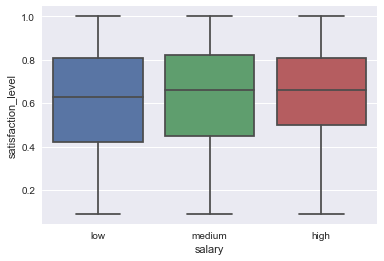

In [130]:
sns.boxplot(x='salary', y='satisfaction_level', data=hr_data); #satisfaction level referring to salary level;
#again <;> is hiding the internal and irrelevant processing step

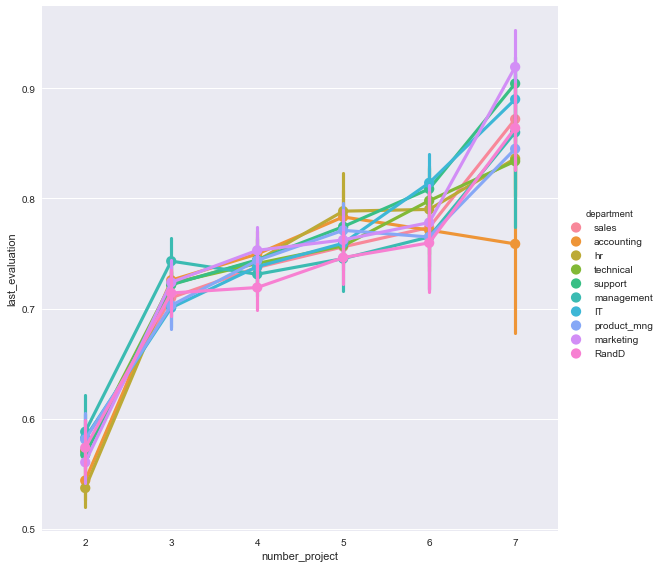

In [131]:
g=sns.factorplot(x='number_project', y='last_evaluation', hue='department', data=hr_data,size=8, aspect=1) 
#multiple graphs on the same plot in seaborn with factorplot, hue==colors in the legend, size (extension of 
#x-axis) and aspect ratio for better distinction (extension of y-axis)
#more information about the plot can be found: http://seaborn.pydata.org/generated/seaborn.factorplot.html

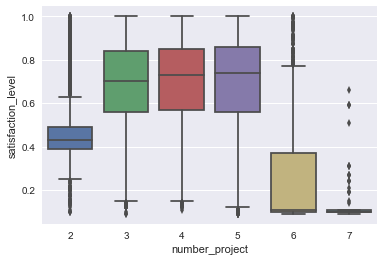

In [132]:
#showing the satisfaction level against the completed number of projects 
sns.boxplot(x='number_project', y='satisfaction_level', data=hr_data_new);
#again <;> is hiding the internal and irrelevant processing step
#more information about the boxplot can be found in the seaborn-documentation:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

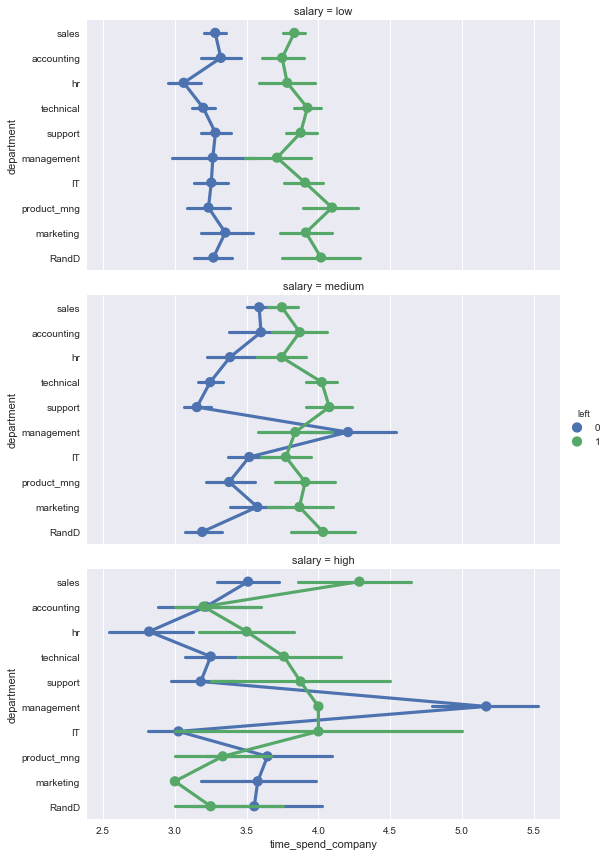

In [133]:
timeplot = sns.factorplot(x='time_spend_company', hue='left', y='department', row='salary', data=hr_data, aspect=2)
#the factorplot draws a categorical plot onto a FacetGrid; It is possible to make rather complex plots using this function
#more information about parameters and using factorplots can be found in documntation:
#https://seaborn.pydata.org/generated/seaborn.factorplot.html

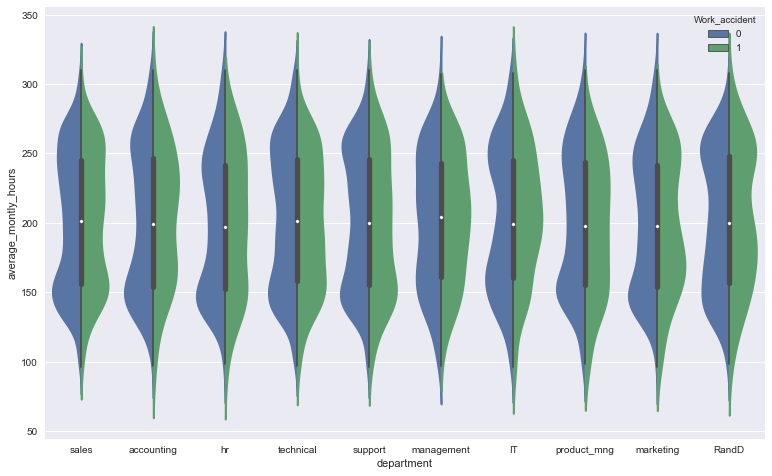

In [134]:
accidentplot = plt.figure(figsize=(10,6)) #advanced plotting with figure module for subplotting; 
#figsize-->w,h tuple in inches constructs the plotting area
#more information about the figure module can be found at: https://matplotlib.org/api/figure_api.html
accidentplotax = accidentplot.add_axes([0,0,1,1]) #Add an axes at position [left, bottom, width, height] 
#where all quantities are in fractions of figure width and height.
accidentplotax = sns.violinplot(x='department', y='average_montly_hours', 
                                hue='Work_accident', split=True, data = hr_data, jitter = 0.47)
#A violin plot plays a similar role as a box and whisker plot. It shows the distribution of quantitative 
#data across several levels of one (or more) categorical variables such that those distributions can be compared.
#more information about parameters and using violinplots can be found in documntation:
#https://seaborn.pydata.org/generated/seaborn.violinplot.html

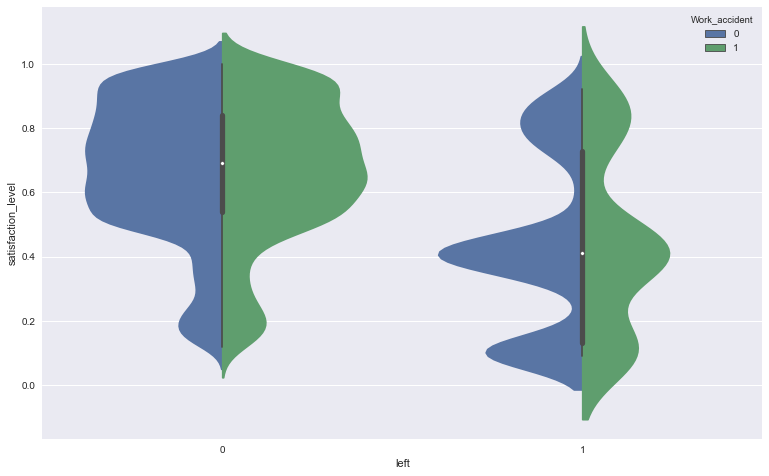

In [135]:
satisaccident = plt.figure(figsize=(10,6)) #we set the overall size of the diagram to 10x6 inches
satisaccidentax = satisaccident.add_axes([0,0,1,1]) #We scale the plot to the axes 

satisaccidentax = sns.violinplot(x='left', hue='Work_accident', y='satisfaction_level', split=True, data=hr_data)
#We plot the entries in work accident with different colors (hue) and show the two different values in one plot for 
#the same argument. 

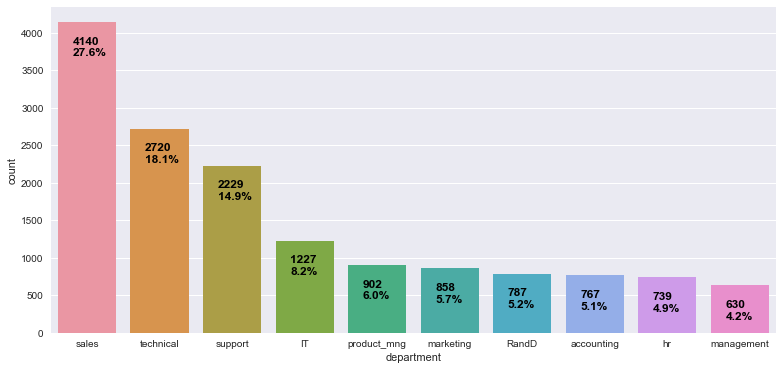

In [136]:
fig, axs = plt.subplots(figsize=(13, 6))

department_plt = sns.countplot(hr_data.department, order = hr_data.department.value_counts().index);

annotate_bars(bar_plt=department_plt, bar_plt_var=hr_data.department, x_offset=0.2, y_offset=450, txt_color="black")

In [137]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
